# Scraping Top Repositories for Topics on Github

PROJECT OUTLINE:
- We're going to scrape https://github.com/topics
- We'll get a list of topics. For each topic, we'll get topic title, topic page URL and topic description
- For each topic, we'll get the top 25 repositories in the topic from the topic page
- For each repository, we'll grab the repo name, username, stars and repo URL
- For each topic we'll create a CSV file in the following format:
```
Repo Name,Username,Stars,Repo URL
three.js,mrdoob,69700,https://github.com/mrdoob/three.js
libgdx,libgdx,18300,https://github.com/libgdx/libgdx
```

## Scrape the list of topics from Github

- use requests to downlaod the page- 
user BS4 to parse and extract informatio
- 
convert to a Pandas dataframe

In [3]:
import requests
from bs4 import BeautifulSoup

def get_topics_page():
    topics_url = 'https://github.com/topics'
    response = requests.get(topics_url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    doc = BeautifulSoup(response.text, 'html.parser') 
    return doc

In [4]:
doc = get_topics_page()

Let's create some helper functions to parse information from the page.

To get topic titles, we can pick p tags with the `class`

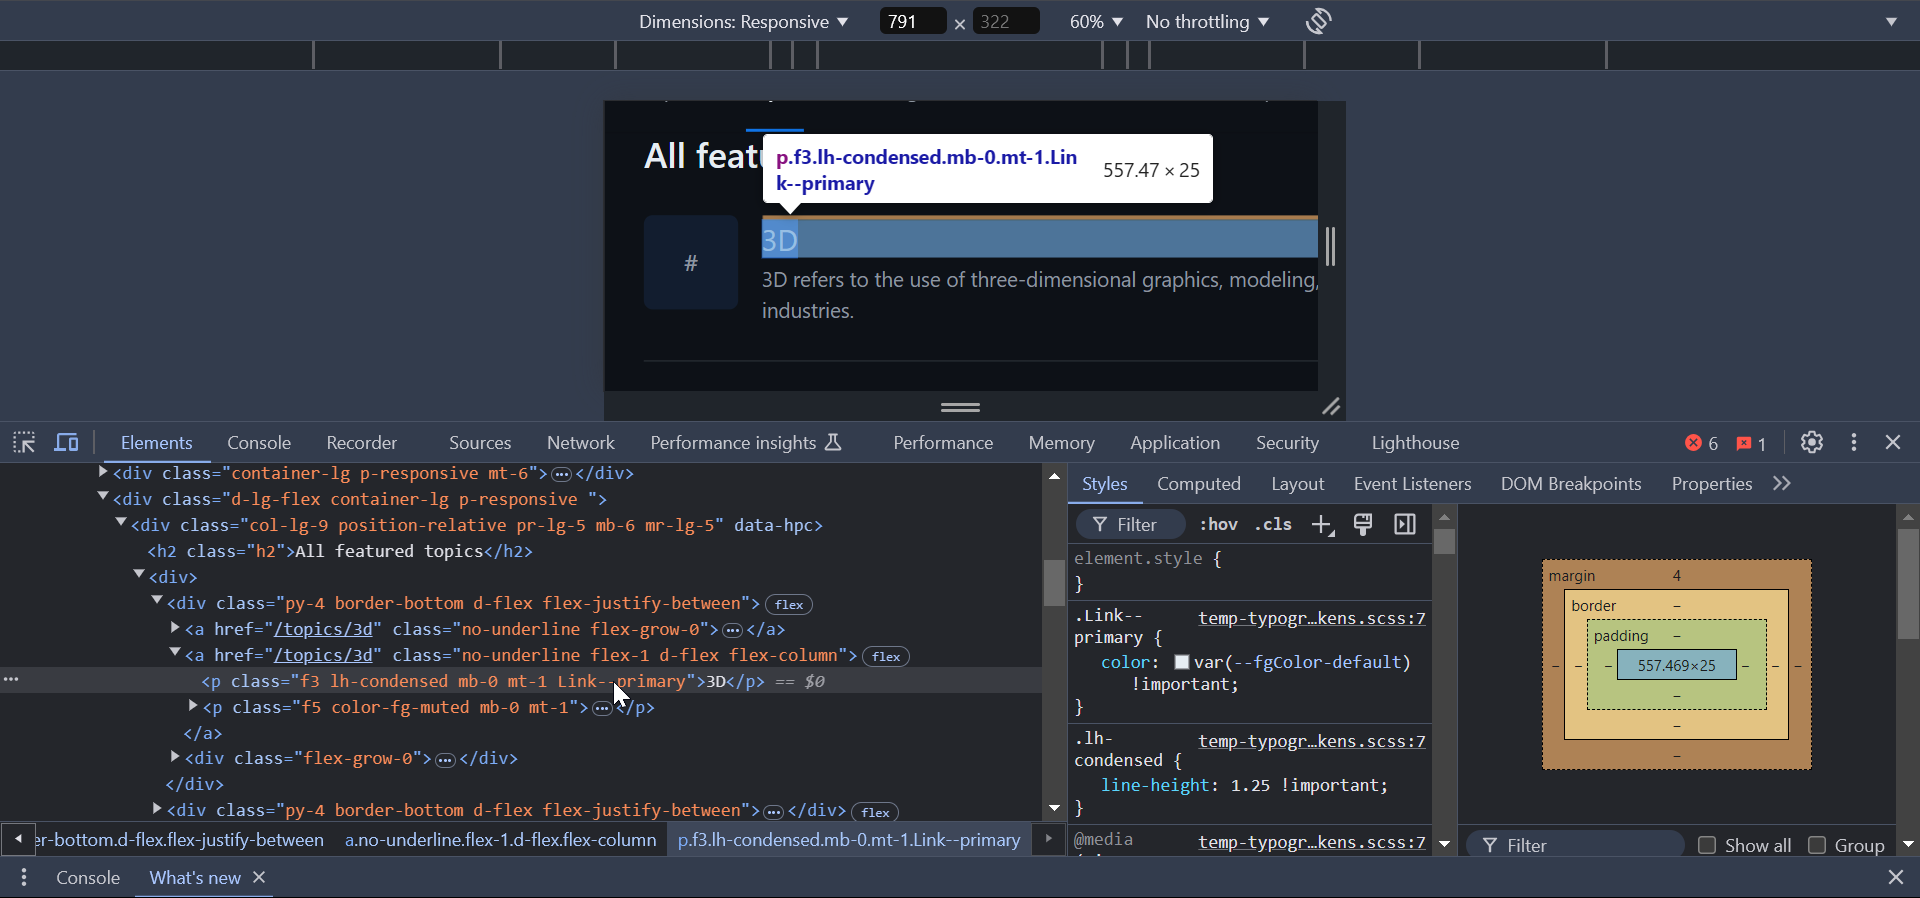

In [6]:
def get_topic_titles(doc):
    selection_class = 'f3 lh-condensed mb-0 mt-1 Link--primary'
    topic_title_tags = doc.find_all('p', {'class': selection_class})
    topic_titles = []
    for tag in topic_title_tags:
        topic_titles.append(tag.text)
    return topic_titles



`get_topic_titles` can be used to get the list of titles

In [8]:
titles = get_topic_titles(doc)

In [10]:
len(titles)

30

In [11]:
titles[:5]

['3D', 'Ajax', 'Algorithm', 'Amp', 'Android']

Similarly defining functions for descriptions and URLs.

In [15]:
def get_topic_descs(doc):
    desc_selector = 'f5 color-fg-muted mb-0 mt-1'
    topic_desc_tags = doc.find_all('p', {'class': desc_selector})
    topic_descs = []
    for tag in topic_desc_tags:
        topic_descs.append(tag.text.strip())
    return topic_descs

In [20]:
descriptions = get_topic_descs(doc)

In [22]:
descriptions[:5]

['3D refers to the use of three-dimensional graphics, modeling, and animation in various industries.',
 'Ajax is a technique for creating interactive web applications.',
 'Algorithms are self-contained sequences that carry out a variety of tasks.',
 'Amp is a non-blocking concurrency library for PHP.',
 'Android is an operating system built by Google designed for mobile devices.']

In [24]:
def get_topic_urls(doc):
    topic_link_tags = doc.find_all('a',{'class': 'no-underline flex-grow-0'})
    topic_urls = []
    base_url = 'https://github.com'
    for tag in topic_link_tags:
        topic_urls.append(base_url + tag['href'])
    return topic_urls

In [26]:
links = get_topic_urls(doc)

In [28]:
links[:5]

['https://github.com/topics/3d',
 'https://github.com/topics/ajax',
 'https://github.com/topics/algorithm',
 'https://github.com/topics/amphp',
 'https://github.com/topics/android']

Putting this all together into a single function

In [31]:
import pandas as pd
import os
def scrape_topics():
    topics_url = 'https://github.com/topics'
    response = requests.get(topics_url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    DOC = BeautifulSoup(response.text, 'html.parser') 
    topics_dict = {
        'title': get_topic_titles(doc),
        'description': get_topic_descs(doc),
        'url': get_topic_urls(doc)
    }
    return pd.DataFrame(topics_dict)

## Get the top 25 resopitories from a topic page

comments

In [35]:
def get_topic_page(topic_url):
    # Download the page
    response = requests.get(topic_url)
    
    # Check successful response
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    
    # Parse using Beautiful Soup
    topic_doc = BeautifulSoup(response.text, 'html.parser')

    return topic_doc

In [37]:
doc = get_topic_page('https://github.com/topics/3d')

todo - Talk about h3 tags

In [39]:
def parse_star_count(stars_str):
    stars_str = stars_str.strip()
    if stars_str[-1] == 'k':
        return int(float(stars_str[:-1]) * 1000)
    return(int(stars_str))

In [40]:
def get_repo_info(h3_tag, star_tag):
    # returns all the required info about the repository
    a_tags = h3_tag.find_all('a')
    username = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url = base_url + a_tags[1]['href']
    stars = parse_star_count(star_tag.text.strip())
    return username, repo_name, stars, repo_url

show an example

In [42]:
def get_topic_repos(topic_doc):
    
    # Get the h3 tags containing repo titles, repo URL and username
    #h3_selection_class = 'f3 color-fg-muted text-normal lh-condensed'
    repo_tags = topic_doc.find_all('h3', {'class': h1_selection_class})
    
    # Get star tags
    star_tags = topic_doc.find_all('span', {'class': 'Counter js-social-count'})

    topic_repos_dict = { 'username': [], 'repo_name': [], 'stars': [], 'repo_url': [] }
    
    #Get repo info
    for i in range(len(repo_tags)):
        repo_info = get_repo_info(repo_tags[i], star_tags[i])
        topic_repos_dict['username'].append(repo_info[0])
        topic_repos_dict['repo_name'].append(repo_info[1])
        topic_repos_dict['stars'].append(repo_info[2])
        topic_repos_dict['repo_url'].append(repo_info[3])
    
    return pd.DataFrame(topic_repos_dict)

show an example

In [48]:
def scrape_topic(topic_url, path):
    
    if os.path.exists(path):
        print("The file {} already exists. Skipping...".format(path))
        return
    topic_df = get_topic_repos(get_topic_page(topic_url))
    topic_df.to_csv(path, index=None)

todo - show an example

## Putting it all together

- We have a function to get the list of topics
- We have a function to create a CSV file for scraped repos from a topics page
- Let's create a function to put them together

In [52]:
def scrape_topics_repos():
    print('Scraping list of Topics')
    topics_df = scrape_topics()

    os.makedirs('data', exist_ok=True)
    
    for index, row in topics_df.iterrows():
        print('Scraping top repositories for "{}"'.format(row['title']))
        scrape_topic(row['url'], 'data/{}.csv'.format(row['title']))

Let's run it to scrape the top repos for all the topics on the first page of https://github.com/topics

In [55]:
scrape_topics_repos()

Scraping list of Topics


We can check that the CSV's were created properly

# Read a display a CSV using pandas

In [59]:
pd.read_csv('data/Android.csv')

,username,repo_name,stars,repo_url
0,flutter,flutter,164000,https://github.com/flutter/flutter
1,facebook,react-native,118000,https://github.com/facebook/react-native
2,justjavac,free-programming-books-zh_CN,111000,https://github.com/justjavac/free-programming-...
3,Genymobile,scrcpy,108000,https://github.com/Genymobile/scrcpy
4,Hack-with-Github,Awesome-Hacking,81900,https://github.com/Hack-with-Github/Awesome-Ha...
5,Solido,awesome-flutter,52800,https://github.com/Solido/awesome-flutter
6,google,material-design-icons,50300,https://github.com/google/material-design-icons
7,tldr-pages,tldr,50200,https://github.com/tldr-pages/tldr
8,wasabeef,awesome-android-ui,50100,https://github.com/wasabeef/awesome-android-ui
9,square,okhttp,45600,https://github.com/square/okhttp
